In [50]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn import metrics
from sklearn.metrics import log_loss
%matplotlib inline
print("Seaborn version: ", sns.__version__)

Seaborn version:  0.9.0


In [51]:
def sigmoid(x):
    s = 1/(1+np.exp(-x))
    return s

In [80]:
def join_feature_name_with_importance_value(features, importances):
    """
    Join via a list of tuples, feature names with their importance values
    :param features: data frame whose features are represented by columns used by classifier
    :param importances: feature importance scores assigned by classifier
    :return: sorted list (highest importances first) of feature,importance tuples
    """
    if features.columns.shape[0] != importances.shape[0]:
        return []

    feature_importances = []
    for item in range(features.columns.shape[0]):
        feature_importances.append((features.columns[item], abs(importances[item])))
    feature_importances_sorted = sorted(feature_importances, reverse=True, key=lambda kv: kv[1])

    return feature_importances_sorted


In [79]:
def display_important_features_regression(classifier, features):
    importances = classifier.coef_[0]
    #print("Importances: ", importances) 
    feature_importances = join_feature_name_with_importance_value(features, importances)
    print('Magnitudes of coefficients')
    for items in feature_importances:
        print(items[0]," ", items[1])

In [52]:
def verify_win_probability(X_test, game_index, model):
    game = X_test.loc[game_index,]
    arg=(np.dot(game,model.coef_.T)) + model.intercept_
    win_prob = sigmoid(arg)[0]
    print("Win probability for game index", game_index, "= ",win_prob)

In [53]:
game_data = pd.read_csv('D1_2015_Training_Data.csv')
print("Number of records= ", game_data.shape[0])
game_data.head()


Number of records=  5515


,scheduled_date,game_id,home_team,market,opp_market,points_game,game_result,opp_points_game,prn_enter_pts_avg,prn_enter_allow_pts_avg,...,opp_enter_allow_fg_pct,opp_enter_off_rebs_avg,opp_enter_allow_off_rebs_avg,opp_enter_def_rebs_avg,opp_enter_ft_att_avg,opp_enter_allow_ft_att_avg,opp_enter_ft_pct,opp_enter_turnover_avg,opp_enter_take_away_avg,opp_enter_win_pct
0,2015-11-13 00:00:00.0000000,e08607b9-ff8f-4bfd-b62d-e49a2c31bb35,True,Eastern Michigan,Vermont,70,True,50,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2015-11-13 00:00:00.0000000,e302d3cb-bbeb-47fa-9f96-0d85eb176c86,False,Fairfield,Yale,57,False,70,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,2015-11-13 00:00:00.0000000,6927bc52-8608-42ab-9d1c-504c48211edd,True,Iowa State,Colorado,68,True,62,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,2015-11-13 00:00:00.0000000,2ab37176-3e33-483a-b3d6-5e2f28361dc2,False,Jacksonville State,Central Michigan,83,False,89,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,2015-11-13 00:00:00.0000000,af588f0f-e314-4f49-b429-dd50d65de7fb,True,Ole Miss,Northwestern State,90,True,76,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [72]:
game_data = game_data[game_data['scheduled_date'] > '2015-12-15'].copy()

encode_game_result = {"game_result": {False: "LOSS", True: "WIN"}}
game_data.replace(encode_game_result, inplace=True)

game_data['prn_enter_off_rating_avg'] = 100*game_data['prn_enter_pts_avg'] / game_data['prn_enter_possesion_avg']
game_data['opp_enter_off_rating_avg'] = 100*game_data['opp_enter_pts_avg'] / game_data['opp_enter_possesion_avg']

game_data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 4061 entries, 1454 to 5514
Data columns (total 50 columns):
scheduled_date                  4061 non-null object
game_id                         4061 non-null object
home_team                       4061 non-null bool
market                          4061 non-null object
opp_market                      4061 non-null object
points_game                     4061 non-null int64
game_result                     4061 non-null object
opp_points_game                 4061 non-null int64
prn_enter_pts_avg               4061 non-null float64
prn_enter_allow_pts_avg         4061 non-null float64
prn_enter_possesion_avg         4061 non-null float64
prn_enter_fg_pct                4061 non-null float64
prn_enter_allow_fg_pct          4061 non-null float64
prn_enter_off_rebs_avg          4061 non-null float64
prn_enter_allow_off_rebs_avg    4061 non-null float64
prn_enter_def_rebs_avg          4061 non-null float64
prn_enter_ft_att_avg            4061 n

In [73]:
game_data['delta_off_rating_avg'] = game_data['prn_enter_off_rating_avg'] - game_data['opp_enter_off_rating_avg'] 
game_data['delta_fg_pct'] = game_data['prn_enter_fg_pct'] - game_data['opp_enter_fg_pct'] 
game_data['delta_off_rebs_avg'] = game_data['prn_enter_off_rebs_avg'] - game_data['opp_enter_off_rebs_avg'] 
game_data['delta_ft_att_avg'] = game_data['prn_enter_ft_att_avg'] - game_data['opp_enter_off_rebs_avg'] 
game_data['delta_ft_pct'] = game_data['prn_enter_ft_pct'] - game_data['opp_enter_ft_pct'] 
game_data['delta_turnover_avg'] = game_data['prn_enter_turnover_avg'] - game_data['opp_enter_turnover_avg'] 
game_data['delta_win_pct'] = game_data['prn_enter_win_pct'] - game_data['opp_enter_win_pct'] 
game_data['delta_allow_pts_avg'] = game_data['prn_enter_allow_pts_avg'] - game_data['opp_enter_allow_pts_avg'] 
game_data['delta_allow_fg_pct'] = game_data['prn_enter_allow_fg_pct'] - game_data['opp_enter_allow_fg_pct'] 
game_data['delta_allow_off_rebs_avg'] = game_data['prn_enter_allow_off_rebs_avg'] - game_data['opp_enter_allow_off_rebs_avg'] 
game_data['delta_allow_ft_att_avg'] = game_data['prn_enter_allow_ft_att_avg'] - game_data['opp_enter_allow_ft_att_avg'] 
game_data['delta_take_away_avg'] = game_data['prn_enter_take_away_avg'] - game_data['opp_enter_take_away_avg'] 

numeric_feature_to_scale = ['delta_off_rating_avg', 'delta_off_rebs_avg', 'delta_ft_att_avg', 'delta_turnover_avg',
                            'delta_allow_pts_avg','delta_allow_off_rebs_avg', 'delta_allow_ft_att_avg', 
                            'delta_take_away_avg']

game_data_scale = game_data[numeric_feature_to_scale].copy()
scaler =StandardScaler()
scaled_features = scaler.fit_transform(game_data_scale.values)
scaled_df = pd.DataFrame(scaled_features, index=game_data_scale.index, columns=game_data_scale.columns)

# Add the categorical columns and previously scaled numerics 
scaled_df['home_team'] = game_data['home_team']
scaled_df['delta_fg_pct'] = game_data['delta_fg_pct']
scaled_df['delta_ft_pct'] = game_data['delta_ft_pct']
scaled_df['delta_win_pct'] = game_data['delta_win_pct']
scaled_df['delta_allow_fg_pct'] = game_data['delta_allow_fg_pct']
scaled_df['delta_fg_pct'] = game_data['delta_fg_pct']
scaled_df['delta_ft_pct'] = game_data['delta_ft_pct']
scaled_df['delta_win_pct'] = game_data['delta_win_pct']
scaled_df['delta_allow_fg_pct'] = game_data['delta_allow_fg_pct']


scaled_df.head()

,delta_off_rating_avg,delta_off_rebs_avg,delta_ft_att_avg,delta_turnover_avg,delta_allow_pts_avg,delta_allow_off_rebs_avg,delta_allow_ft_att_avg,delta_take_away_avg,home_team,delta_fg_pct,delta_ft_pct,delta_win_pct,delta_allow_fg_pct
1454,-1.580003,0.417352,0.039621,0.664381,1.214159,1.350960,0.942849,-0.126048,False,-0.082365,0.009076,-0.33,0.020272
1455,-0.548556,1.230598,0.637051,1.245262,0.018863,1.367339,0.457101,-0.340824,False,0.009318,-0.088361,0.04,-0.081819
1456,-0.130834,0.345719,-0.500911,0.618522,0.291855,2.066138,0.248924,-0.302164,False,-0.006508,0.039627,-0.07,0.011806
1457,2.001609,-1.483033,-1.894914,-2.031109,-0.033439,-1.455155,-1.138926,-1.272948,False,0.084848,-0.047849,0.24,0.050610
1458,-1.584161,1.175820,1.035338,1.877097,-1.043764,0.362815,-0.435749,0.522573,False,0.000994,-0.161619,-0.21,-0.050068


In [74]:
X = scaled_df
y= game_data['game_result'].copy()
y = pd.get_dummies(y, columns=['game_result'], drop_first=True)
y=y.WIN
X = pd.get_dummies(X, columns=['home_team'], drop_first=True)
print(X.shape)
X.head()

(4061, 13)


,delta_off_rating_avg,delta_off_rebs_avg,delta_ft_att_avg,delta_turnover_avg,delta_allow_pts_avg,delta_allow_off_rebs_avg,delta_allow_ft_att_avg,delta_take_away_avg,delta_fg_pct,delta_ft_pct,delta_win_pct,delta_allow_fg_pct,home_team_True
1454,-1.580003,0.417352,0.039621,0.664381,1.214159,1.350960,0.942849,-0.126048,-0.082365,0.009076,-0.33,0.020272,0
1455,-0.548556,1.230598,0.637051,1.245262,0.018863,1.367339,0.457101,-0.340824,0.009318,-0.088361,0.04,-0.081819,0
1456,-0.130834,0.345719,-0.500911,0.618522,0.291855,2.066138,0.248924,-0.302164,-0.006508,0.039627,-0.07,0.011806,0
1457,2.001609,-1.483033,-1.894914,-2.031109,-0.033439,-1.455155,-1.138926,-1.272948,0.084848,-0.047849,0.24,0.050610,0
1458,-1.584161,1.175820,1.035338,1.877097,-1.043764,0.362815,-0.435749,0.522573,0.000994,-0.161619,-0.21,-0.050068,0


In [75]:
print(y.shape)

(4061,)


In [76]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state= 10)
print(X_train.shape)
print(y_train.shape)
print(X_test.shape)
print(y_test.shape)
X_train.head()

(3248, 13)
(3248,)
(813, 13)
(813,)


,delta_off_rating_avg,delta_off_rebs_avg,delta_ft_att_avg,delta_turnover_avg,delta_allow_pts_avg,delta_allow_off_rebs_avg,delta_allow_ft_att_avg,delta_take_away_avg,delta_fg_pct,delta_ft_pct,delta_win_pct,delta_allow_fg_pct,home_team_True
2253,0.240355,0.029690,-0.068485,0.226173,0.154083,0.231790,0.278994,-0.104571,0.008276,0.038769,0.13,0.013425,0
2062,0.623339,0.746021,-0.165212,0.587950,0.502339,-0.876462,1.694601,0.140273,0.020263,0.024127,0.17,0.014688,1
2042,-0.092314,0.126605,0.153418,0.114073,-0.491402,-0.658087,-1.321660,-1.934456,-0.005629,0.041358,0.08,0.001168,1
2854,0.768279,-1.116440,-0.296077,-1.761050,2.082886,1.574795,-0.317782,-0.980854,0.023906,0.031563,-0.45,0.082292,0
5510,1.317384,-0.484383,0.807746,1.265644,2.195144,1.269070,0.457101,0.569824,0.016722,0.088878,0.03,0.037111,1


In [77]:
logreg = LogisticRegression()

result = logreg.fit(X_train,y_train)

print("Coeffs ",logreg.coef_)
print("Intercept ", logreg.intercept_)

Coeffs  [[ 0.67384699  0.41162371 -0.04594093 -0.05493934 -0.42000961 -0.10005683
  -0.05055625  0.12213243  0.130925   -0.01416497  0.59651613 -1.1490823
   1.12863394]]
Intercept  [-0.56563998]


In [81]:
display_important_features_regression(logreg, X_train)

Magnitudes of coefficients
delta_allow_fg_pct   1.1490823001306483
home_team_True   1.128633943630021
delta_off_rating_avg   0.67384698701247
delta_win_pct   0.5965161330319584
delta_allow_pts_avg   0.4200096124210856
delta_off_rebs_avg   0.4116237142714947
delta_fg_pct   0.13092499510504604
delta_take_away_avg   0.1221324261768394
delta_allow_off_rebs_avg   0.10005683294974244
delta_turnover_avg   0.05493933903472805
delta_allow_ft_att_avg   0.050556249267706486
delta_ft_att_avg   0.04594092800404199
delta_ft_pct   0.014164971845119178


In [82]:
y_pred = logreg.predict(X_test)
print("LR model accuracy is %2.2f" % metrics.accuracy_score(y_test, y_pred))

LR model accuracy is 0.72


In [83]:
prediction_probabilities = logreg.predict_proba(X_test)
prediction_probabilities[:,1]
pred_probs = pd.Series(prediction_probabilities[:,1], index=X_test.index)
predictions = pd.Series(y_pred, index=y_test.index)
print(y_pred.shape)

(813,)


In [84]:
# Retrieve the non-normalized game stats
test_games = game_data[game_data.index.isin(X_test.index)].copy()
test_games.shape

test_games['predicted_result'] = predictions
test_games['pred_win_prob'] = pred_probs

encode_pred_result = {"predicted_result": {0: "LOSS", 1: "WIN"}}
test_games.replace(encode_pred_result, inplace=True)

test_games.head()

,scheduled_date,game_id,home_team,market,opp_market,points_game,game_result,opp_points_game,prn_enter_pts_avg,prn_enter_allow_pts_avg,...,delta_allow_pts_avg,delta_allow_fg_pct,delta_allow_off_rebs_avg,delta_allow_ft_att_avg,delta_take_away_avg,prn_enter_off_rating_avg,opp_enter_off_rating_avg,delta_off_rating_avg,predicted_result,pred_win_prob
1455,2015-12-15 00:00:00.0000000,85f37e83-6b6f-4512-b97a-ea06dca185cd,False,Coastal Carolina,Wofford,71,WIN,63,66.67,71.00,...,0.29,-0.081819,2.53,2.07,-0.83,84.929936,89.662763,-4.732826,LOSS,0.350797
1463,2015-12-15 00:00:00.0000000,a2064df4-beee-4969-94d5-9b2c08160342,False,Prairie View A&M,Tulane,49,LOSS,63,57.25,79.75,...,13.19,0.089834,1.44,6.46,2.22,71.095933,87.875105,-16.779172,LOSS,0.034513
1470,2015-12-16 00:00:00.0000000,23ac6027-7c73-4acf-820c-b0d170ccf342,False,DePaul,Stanford,60,LOSS,79,70.78,70.22,...,0.79,-0.004076,-0.53,6.08,1.47,93.845021,90.355970,3.489051,LOSS,0.251092
1471,2015-12-16 00:00:00.0000000,3e705f68-d06a-4c1b-8b0f-06e87be50430,False,Drexel,South Carolina,54,LOSS,79,68.67,73.17,...,4.79,0.070731,0.20,8.70,-4.46,89.569566,96.486175,-6.916609,LOSS,0.055180
1479,2015-12-16 00:00:00.0000000,6966e23e-f98e-48b1-a24e-70c7245dd67e,False,Jackson State,Miami (OH),53,LOSS,64,69.88,74.75,...,6.00,-0.019821,0.00,10.38,-0.13,79.862857,88.124793,-8.261935,LOSS,0.228183


Text(0.5,1,'Probabilities For Missed Predictions')

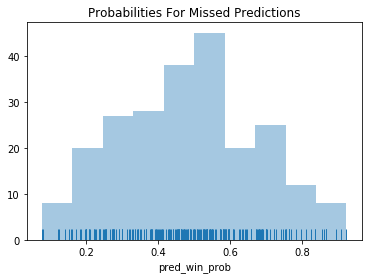

In [85]:
missed_predictions = test_games[test_games['game_result'] != 
                                test_games['predicted_result']].sort_values(by='pred_win_prob', ascending=False)

missed_predictions.pred_win_prob

sns.distplot(missed_predictions.pred_win_prob, kde=False, rug=True).set_title("Probabilities For Missed Predictions")

Text(0.5,1,'Probabilities For Correct Predictions')

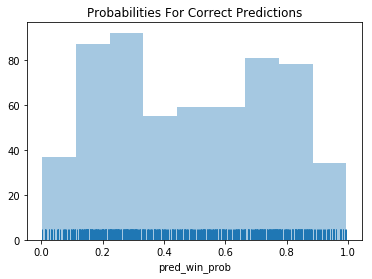

In [86]:
correct_predictions = test_games[test_games['game_result'] == 
                                test_games['predicted_result']].sort_values(by='pred_win_prob', ascending=False)

sns.distplot(correct_predictions.pred_win_prob, kde=False, rug=True).set_title("Probabilities For Correct Predictions")

In [87]:
cnf_matrix = metrics.confusion_matrix(y_test, y_pred)
cnf_matrix

array([[300, 110],
       [121, 282]], dtype=int64)

Text(0.5,257.44,'Predicted label')

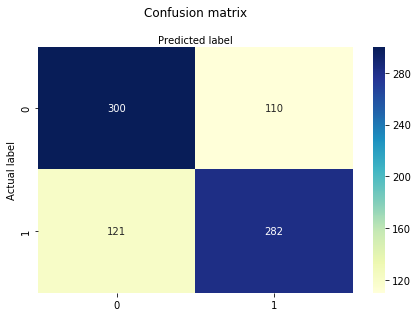

In [88]:
class_names=[0,1] # name  of classes
fig, ax = plt.subplots()
tick_marks = np.arange(len(class_names))
plt.xticks(tick_marks, class_names)
plt.yticks(tick_marks, class_names)
# create heatmap
sns.heatmap(pd.DataFrame(cnf_matrix), annot=True, cmap="YlGnBu" ,fmt='g')
ax.xaxis.set_label_position("top")
plt.tight_layout()
plt.title('Confusion matrix', y=1.1)
plt.ylabel('Actual label')
plt.xlabel('Predicted label')

In [89]:
print("Accuracy:",metrics.accuracy_score(y_test, y_pred))
print("Precision:",metrics.precision_score(y_test, y_pred))
print("Recall:",metrics.recall_score(y_test, y_pred))

Accuracy: 0.7158671586715867
Precision: 0.7193877551020408
Recall: 0.6997518610421837


In [90]:
print("\n\n---Logistic Model---")
logit_roc_auc = metrics.roc_auc_score(y_test, y_pred)
print("Base Rate AUC= %2.2f" % logit_roc_auc)
print(metrics.classification_report(y_test, y_pred))



---Logistic Model---
Base Rate AUC= 0.72
             precision    recall  f1-score   support

          0       0.71      0.73      0.72       410
          1       0.72      0.70      0.71       403

avg / total       0.72      0.72      0.72       813



In [91]:
verify_win_probability(X_test, 1455, logreg)

Win probability for game index 1455 =  0.35079651026728326


In [93]:
print("Log loss= ",log_loss(y_test, prediction_probabilities))

Log loss=  0.546322398045537
